# Raport z projektu 2 - klasteryzacja
Grupa: Kacper Staroń, Jakub Szypuła, Anna Urbala

## Wstęp teoretyczny

### Na czym polega klasteryzacja?
Klasteryzacja polega na szukaniu skupień w zbiorze. Pozwala znaleźć naturalne podziały, wyodrębnić pewne struktury.

### Przykładowe algorytmy
Jednymi z najbardziej popularnych algorytmów są:

- **K-means** - iteracyjnie przypisuje punkty do skupień (do punktów wybranych jako środki), na podstawie otrzymanych skupień wylicza nowe ich środki; trzeba samemu dobrać liczbę skupień
- **hierarchiczne** (z różnymi typami połączeń klastrów) - dzieli istniejące klastry na kolejne klastry, póki odległość między nimi nie jest za mała (odległość zależy od typu połączenia, minimalną odległość można zdefiniować samemu)
- **DBSCAN** - znajduje punkty o wysokiej gęstości i na ich podstawie rozszerza klastry

### Ocena *jakości* klastrowania
Istnieje wiele różnych metryk oceny jakości klastrowania. Każda z nich zwraca uwagę na coś innego, dlatego powinny być dobierane na podstawie tego, co chcemy osiągnąć przez klastrowanie. Oto kilka przykładów:

- **metryka silhouette** - mierzy, jak dobrze pasują punkty do klastrów, niestety premiuje okrągłe klastry
- **indeks Daviesa-Bouldina** - miara podobieństwa klastra z najbardziej podobnym klastrem, podobieństwo liczone na podstawie odległości między klastrami i wewnątrz klastrów
- **różne miary odnośnie odległości między klastrami/w klastrze** - porównanie różnych miar (średnia ogległość między klastrami, najmniejsza odległość między klastrami, odległość punktu od środka klastra) daje nam pewną możliwość oceny klastrowania z uwzględnieniem parametrów, na których nam najbardziej zależy


## Opis zbioru danych
Wybrany przez nas zbiór danych to: [A study of Asian Religious and Biblical Texts Data Set](https://archive.ics.uci.edu/ml/datasets/A+study+of++Asian+Religious+and+Biblical+Texts). Dotyczy świętych tekstów różnych religii.

Składa się z 3 plików dotyczących tych samych danych, ale w innym formacie.

- `Complete_data .txt` - zawiera nieobrobiony tekst ksiąg
- `AllBooks_baseline_DTM_Unlabelled.csv` - tekst ksiąg w reprezentacji *bag-of-words* - słowa to kolumny, księgi wiersze, wartości w komórkach to liczba wystąpień danego słowa w księdze
- `AllBooks_baseline_DTM_Labelled.csv` - jak wyżej, ale z podpisem ksiąg

## Cel projektu
Celem projektu jest znalezienie sensownego podziału między księgami. Być może podział ten będzie w jakimś stopniu zgodny z podziałem na religie.

## Opis rozwiązania
Pierwszym problemem, który musieliśmy rozwiązać była obróbka oryginalnego tekstu. Niestety przez to, że pewne słowa występują bardzo rzadko, mogło być dość problematyczne operowanie na całej tabeli *AllBooks_baseline_DTM_Unlabelled*. Postanowiliśmy położyć pewien nacisk na zliczenie częstotliwości występowania słów w księgach.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


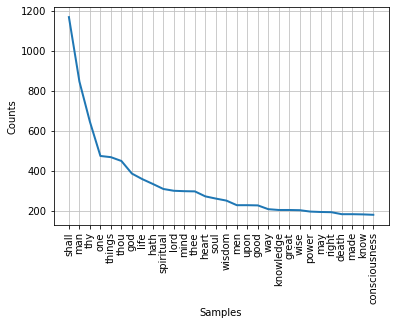

In [8]:
f = open('AsianReligionsData/Complete_data .txt')
content = f.read()
lines = content.split("\n")
data = []

# wybranie tylko linii z danymi
for i in range(len(lines)):
    if i % 2 == 1:
        data.append(lines[i])

f.close()

import nltk
from nltk.probability import FreqDist

# najczestsze slowa

def tokenize(text):
    words = nltk.word_tokenize(text)
    return [word.lower() for word in words if word.isalpha()]

def word_frequency(words):
    return FreqDist(words)

# stop words, ktore nalezy odfiltrowac
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))

# Czestotliwosci zsumowane ze wszystkich ksiag

data_str = " ".join(data)
words_str = tokenize(data_str)
filtered_words_str = [word for word in words_str if word not in stop_words]
filtered_freq_str = word_frequency(filtered_words_str)
filtered_freq_str.plot(30, cumulative=False)

Powyższy wykres zasugerował nam również, że porównywanie słów poza TOP ok. 30-50 pod kątem częstotliwości prawdopodobnie nie ma sensu, gdyż nie będą występowały w prawie żadnej księdze. Być może warto spróbować porównywania korpusów.

Zainteresowało nas również, jakie słowa są najpopularniejsze w zależności od księgi.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\finwe\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


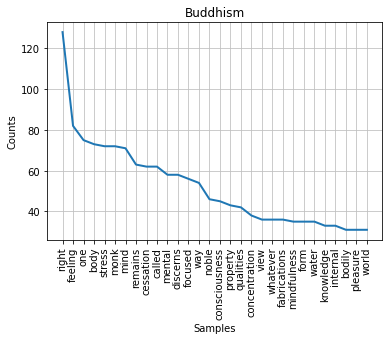

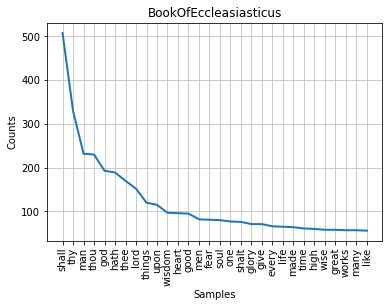

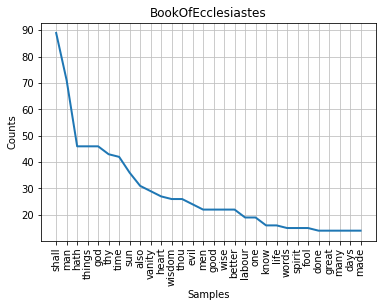

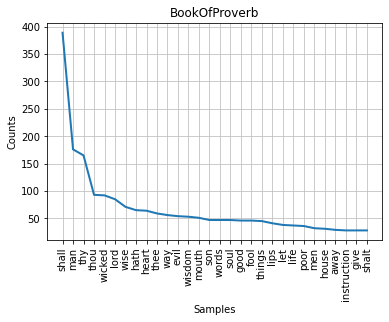

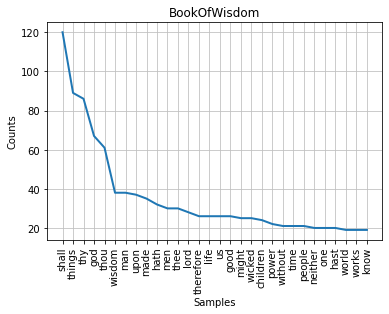

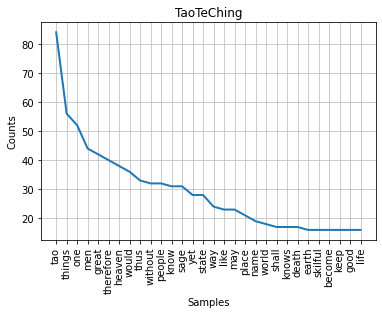

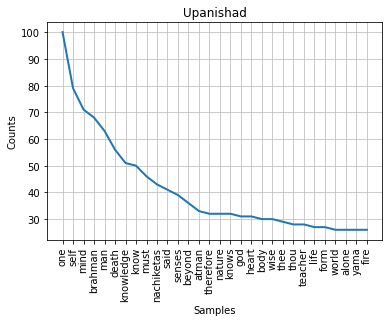

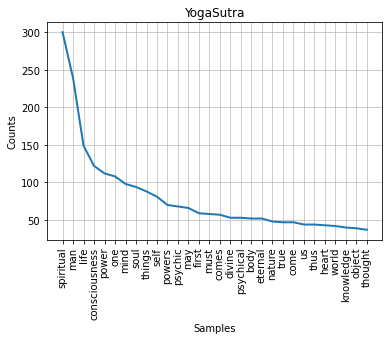

In [7]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()

labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
groups = set(labels_general)

group_ids = {}
for g in groups:
    tmp = [i for i in range(len(labels_general)) if labels_general[i] == g]
    group_ids[g] = tmp

import copy
books = {}
for g in groups:
    tmp = ""
    for i in group_ids[g]:
        tmp += data[i]
    books[g] = copy.copy(tmp)
    
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
# oczyszczenie ze stopwords
stop_words = set(stopwords.words("english"))

categories = ['Buddhism', 'BookOfEccleasiasticus', 'BookOfEcclesiastes', 'BookOfProverb', 'BookOfWisdom', 'TaoTeChing', 'Upanishad', 'YogaSutra']

for category in categories:
    cat_words_str = tokenize(books[category])
    cat_filtered_words_str = [word for word in cat_words_str if word not in stop_words]
    cat_filtered_freq_str = word_frequency(cat_filtered_words_str)
    cat_filtered_freq_str.plot(30, cumulative=False, title=category)

### Jak liczyć odległości?
Zdefiniowaliśmy 2 metody liczenia odległości między klastrami:

- cały tekst (z wyłączeniem stop words) przekształcony do miar TF-IDF i na tych miarach klasyczna odległość euklidesowa
- ograniczenie tekstu do $k$ najczęściej występujących słów (w naszym przypadku przyjęliśmy $k=30$) i na tym analogiczne operacje

In [9]:
import string
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import TfidfVectorizer

def process_whole_text(text, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
 
    return tokens
    
def get_first_i_without_order(text, i, stem=True):
    """ Tokenize text and stem words removing punctuation """
    tokens = word_tokenize(text)
    tokens = [word.lower() for word in tokens if word.isalpha()]
 
    if stem:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(t) for t in tokens]
        
    freq = FreqDist(tokens)
    most_comm = freq.most_common(i)
    tokens = [token[0] for token in most_comm]
    
    return tokens

from scipy.spatial import distance
import numpy as np

# def two_class

def min_interclust_dist(X, label):
    clusters = set(label)
    global_min_dist = np.inf
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        for cluster_j in clusters:
            if cluster_i != cluster_j:
                cluster_j_idx = np.where(label == cluster_j)
                interclust_min_dist = np.min(distance.cdist(X[cluster_i_idx], X[cluster_j_idx]))
                global_min_dist = np.min([global_min_dist, interclust_min_dist])
    return global_min_dist

def _inclust_mean_dists(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        inclust_dist = np.mean(distance.pdist(X[cluster_i_idx]))
        inclust_dist_list.append(inclust_dist)
    return inclust_dist_list

def mean_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.mean(inclust_dist_list)

def std_dev_of_inclust_dist(X, label):
    inclust_dist_list = _inclust_mean_dists(X, label)
    return np.std(inclust_dist_list)

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X[cluster_i_idx], axis=0, keepdims=True)
        inclust_dist = np.mean(distance.cdist(X[cluster_i_idx], cluster_i_mean))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

def clusters_num(X, label):
    return len(set(label))

def count_clustering_scores(X, cluster_num, model, score_fun):
    if isinstance(cluster_num, int):
        cluster_num_iter = [cluster_num]
    else:
        cluster_num_iter = cluster_num
        
    scores = []    
    for k in cluster_num_iter:
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        wcss = score_fun(X, labels)
        scores.append(wcss)
    
    if isinstance(cluster_num, int):
        return scores[0]
    else:
        return scores

def prepare_X(texts, process_function):
    vectorizer = TfidfVectorizer(tokenizer=process_function,
                                 stop_words=stopwords.words('english'),
                                 max_df=0.5,
                                 min_df=0.1,
                                 lowercase=True)
 
    return vectorizer.fit_transform(texts)

import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans


metrices = {
            'min dist between clusters': min_interclust_dist,
            'mean dist in clust': mean_inclust_dist,
            'std dev dist in clust': std_dev_of_inclust_dist,
            'mean dist to clust center': mean_dist_to_center,
            'silhouette': silhouette_score,
            'davies-bouldin': davies_bouldin_score,
            'clusters num': clusters_num
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

### Wartości metryk dla wstępnych modeli

In [12]:
# Get whole text
X = prepare_X(data, process_whole_text).toarray()
whole_text_metrics = calculate_metrics(X, 3) # dosc dobre wartosci dawalo rowniez n=8
whole_text_metrics

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: Run

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.792830,1.174056,0.119025,0.827009,0.041090,3.334753,3.0
Agglomerative complete linkage,0.672026,1.249152,0.102270,0.882001,0.023263,6.741079,3.0
Agglomerative average linkage,0.852063,1.088455,0.170585,0.723249,0.034598,2.147604,3.0
Agglomerative single linkage,1.000000,NaN,NaN,0.311270,-0.015797,0.985968,3.0
Mini Batch KMeans,0.664010,1.208416,0.127583,0.854938,0.054512,4.167853,3.0
Kmeans,0.637202,1.192586,0.125327,0.842309,0.053564,3.761003,3.0


In [13]:
# Get first 30
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
calculate_metrics(X, 10)

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\numpy\core\fromnumeric.py:3334: Run

,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin,clusters num
Agglomerative ward linkage,0.478933,0.658365,0.226952,0.488231,0.323363,1.270449,10.0
Agglomerative complete linkage,0.440409,0.696521,0.144138,0.525002,0.276652,1.450325,10.0
Agglomerative average linkage,0.494142,0.595802,0.276128,0.443627,0.298544,1.250900,10.0
Agglomerative single linkage,0.665383,NaN,NaN,0.116205,0.000082,1.239330,10.0
Mini Batch KMeans,0.413122,0.651808,0.128103,0.484504,0.305496,1.169979,10.0
Kmeans,0.404198,0.649520,0.203858,0.498212,0.336954,1.255298,10.0


W przypadku procesowania całego tekstu metryka silhouette dała nam bardzo niskie wartości, w przypadku top 30 słów znacznie lepsze, ale nieco sprzeczne z indeksem Daviesa-Bouldina. 

Postanowiliśmy jednak sprawdzić jeszcze bardzo popularne algorytmy DBSCAN i GMM.

#### DBSCAN

In [14]:
from sklearn import cluster, mixture

X = prepare_X(data, process_whole_text).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


failed for  silhouette 0.1
failed for  davies-bouldin 0.1
failed for  silhouette 0.2
failed for  davies-bouldin 0.2
failed for  silhouette 0.30000000000000004
failed for  davies-bouldin 0.30000000000000004
failed for  silhouette 0.4
failed for  davies-bouldin 0.4


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.2,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.3,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.4,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
0.5,2.0,0.533469,0.915165,0.405571,0.633499,-0.030633,1.556112
0.6,3.0,0.548840,0.865496,0.323055,0.596172,-0.022660,1.712393
0.7,5.0,0.633533,0.850090,0.249306,0.573131,-0.029162,1.910902
0.8,7.0,0.649848,0.891919,0.199291,0.601810,-0.005624,2.101353
0.9,10.0,0.710173,1.000851,0.164401,0.677092,0.037307,2.686207


In [15]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
eps_list = np.arange(0.1, 1, 0.1)
df = pd.DataFrame()
for eps in eps_list:
    dbscan = cluster.DBSCAN(eps=eps)
    labels = dbscan.fit_predict(X)
    df.loc[eps, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[eps, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for ", metric_key, eps)
df

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
0.1,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.2,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.3,29.0,0.350730,0.041254,0.218298,0.029553,0.385813,0.985460
0.4,33.0,0.412582,0.067941,0.216107,0.050334,0.419838,1.037136
0.5,40.0,0.380407,0.192560,0.234998,0.148261,0.522180,1.164041
0.6,15.0,0.417129,0.414437,0.405827,0.309569,0.157025,2.062636
0.7,4.0,0.591547,0.566451,0.570819,0.389698,0.001176,1.931544
0.8,3.0,0.838272,0.411164,0.581474,0.295838,0.001540,1.623308
0.9,2.0,1.000000,0.616319,0.616319,0.443617,-0.056503,1.947414


Niestety liczba $>20$ klastrów nas raczej nie interesuje, więc będziemy się raczej trzymać 3-10.

#### GMM

In [16]:
X = prepare_X(data, process_whole_text).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.319530,0.000000,0.933880,NaN,NaN
2,2.0,0.767523,1.183476,0.149325,0.835472,0.044869,2.854261
3,3.0,0.567902,1.191949,0.125451,0.840872,0.053851,3.709670
4,4.0,0.567902,1.214576,0.122724,0.857014,0.057750,4.705296
5,5.0,0.567902,1.208452,0.103626,0.850891,0.064394,4.197316
6,6.0,0.567902,1.109401,0.146188,0.775405,0.044036,3.206094
7,7.0,0.567902,1.201306,0.104794,0.844920,0.054806,4.165264
8,8.0,0.467027,1.204595,0.092260,0.846908,0.063811,4.076255
9,9.0,0.570269,1.177950,0.110306,0.825589,0.054912,3.751343


In [17]:
X = prepare_X(data, partial(get_first_i_without_order, i=30)).toarray()
df = pd.DataFrame()
for n in range(1,10):
    gmm = mixture.GaussianMixture(n_components=n)
    labels = gmm.fit_predict(X)
    df.loc[n, "clusters num"] = len(set(labels))
    for metric_key in metrices:
        try:
            df.loc[n, metric_key] =  metrices[metric_key](X, labels)
        except:
            print("failed for", metric_key, n)
df

c:\users\staro\appdata\local\programs\python\python38\lib\site-packages\sklearn\feature_extraction\text.py:382: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'could', 'doe', 'dure', 'ha', 'hi', 'might', 'must', 'need', 'onc', 'onli', 'ourselv', 'sha', 'themselv', 'thi', 'veri', 'wa', 'whi', 'wo', 'would', 'yourselv'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


failed for silhouette 1
failed for davies-bouldin 1


,clusters num,min dist between clusters,mean dist in clust,std dev dist in clust,mean dist to clust center,silhouette,davies-bouldin
1,1.0,inf,1.172193,0.000000,0.835972,NaN,NaN
2,2.0,0.304479,1.104893,0.020458,0.792054,0.104418,3.062796
3,3.0,0.424778,1.066311,0.053379,0.776569,0.131291,2.808196
4,4.0,0.459540,0.963344,0.100758,0.703090,0.167262,2.379645
5,5.0,0.451096,0.853885,0.121084,0.630319,0.205115,1.934188
6,6.0,0.469149,0.854616,0.085735,0.622460,0.223713,1.841544
7,7.0,0.404198,0.831437,0.075666,0.612542,0.240266,1.716633
8,8.0,0.466978,0.741128,0.110436,0.543700,0.281380,1.526985
9,9.0,0.413122,0.716583,0.262350,0.539521,0.276751,1.570128


Dla $n=8$ (czyli tyle, ile jest ksiąg!) mamy całkiem sensowne wartości.

### Analiza sentymentów
Ponieważ dane z analizowanego zbioru są słowami języka naturalnego, interesujących zależności możemy poszukać stosując analizę sentymentów.

In [11]:
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer


def text_emotion(tekst):
    filepath = ('AsianReligionsData/NRC-Emotion-Lexicon-Wordlevel-v0.92.txt')
    emolex_df = pd.read_csv(filepath,
                            names=["word", "emotion", "association"],
                            sep='\t')
    emolex_words = emolex_df.pivot(index='word',
                                   columns='emotion',
                                   values='association').reset_index()
    document = word_tokenize(tekst)
    emotions = emolex_words.columns.drop('word')
    emo_df = pd.DataFrame(0, index=range(0, len(document)), columns=emotions)
    for i in range(0, len(document)):
        word = document[i]
        emo_score = emolex_words[emolex_words.word == word]
        if not emo_score.empty:
            for emotion in list(emotions):
                emo_df.at[i, emotion] += emo_score[emotion]

    return emo_df

Każdej księdze możemy przypisać średnią emocję, tzn. dla każdej z 10 emocji 
* $anger$, 
* $anticipation$, 
* $disgust$, 
* $fear$, 
* $joy$, 
* $negative$, 
* $positive$, 
* $sadness$, 
* $surprise$, 
* $trust$. 

każdej księdze przypisujemy średnią emocji danej księgi we wszystkich słowach z tej księgi.

#### Buddhism

In [31]:
buddhism_emo = text_emotion(books['Buddhism'])

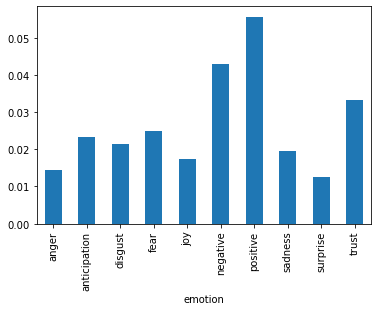

In [32]:
buddhism_emo = buddhism_emo.sum()/buddhism_emo.shape[0]
buddhism_emo.plot.bar()

#### BookOfEccleasiasticus

In [33]:
boe_emo = text_emotion(books['BookOfEccleasiasticus'])

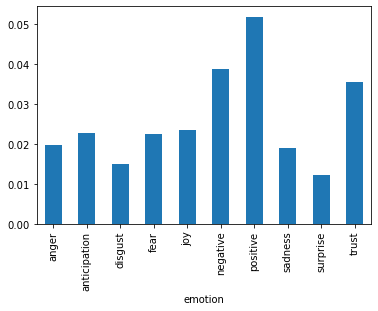

In [34]:
boe_emo = boe_emo.sum()/boe_emo.shape[0]
boe_emo.plot.bar()

#### BookOfEcclesiastes

In [35]:
boe2_emo = text_emotion(books['BookOfEcclesiastes'])

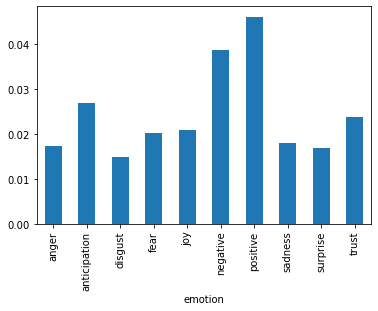

In [36]:
boe2_emo = boe2_emo.sum()/boe2_emo.shape[0]
boe2_emo.plot.bar()

#### BookOfProverb

In [37]:
bop_emo = text_emotion(books['BookOfProverb'])

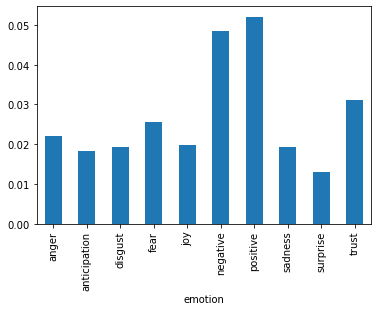

In [38]:
bop_emo = bop_emo.sum()/bop_emo.shape[0]
bop_emo.plot.bar()

#### BookOfWisdom

In [39]:
bow_emo = text_emotion(books['BookOfWisdom'])

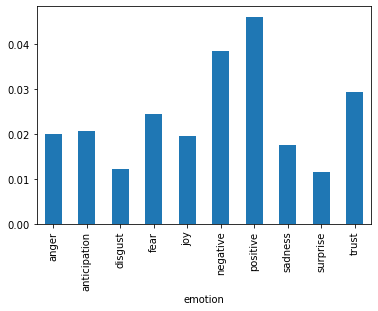

In [40]:
bow_emo = bow_emo.sum()/bow_emo.shape[0]
bow_emo.plot.bar()

#### TaoTeChing

In [41]:
ttc_emo = text_emotion(books['TaoTeChing'])

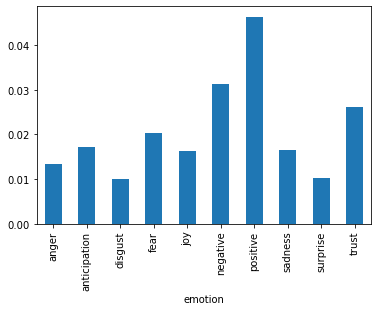

In [42]:
ttc_emo = ttc_emo.sum()/ttc_emo.shape[0]
ttc_emo.plot.bar()

#### Upanishad

In [43]:
Upanishad_emo = text_emotion(books['Upanishad'])

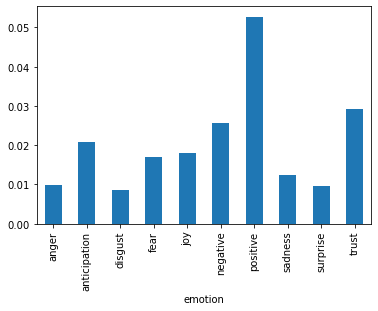

In [44]:
Upanishad_emo = Upanishad_emo.sum()/Upanishad_emo.shape[0]
Upanishad_emo.plot.bar()

#### YogaSutra

In [45]:
ys_emo = text_emotion(books['YogaSutra'])

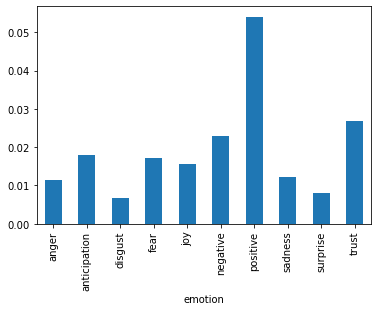

In [46]:
ys_emo = ys_emo.sum()/ys_emo.shape[0]
ys_emo.plot.bar()

Na tej podstawie możemy podejrzewać istnienie wzoru w strukturze danych zakodowanego w sentymentach odpowiadającego podziałowi rozdziałów na księgi z których pochodzą.

Analogicznie jak wyżej, każdemu rozdziałowi możemy przypisać średnią emocję, tzn. dla każdej z 10 wymienionych wyżej emocji każdemu rozdziałowi przypisujemy średnią emocji danego rozdziału we wszystkich słowach z tego rozdziału.

In [17]:
from sklearn import preprocessing
tmp = text_emotion(data[0])
tmp = tmp.sum()/tmp.shape[0]
average_sentiments = pd.DataFrame(copy.copy([tmp]))
first = True
for chapter in data:
    if first:
        first = False
    else:
        tmp = text_emotion(chapter)
        tmp = tmp.sum()/tmp.shape[0]
        average_sentiments = average_sentiments.append(copy.copy([tmp]))
for chapter in data:
    if first:
        first = False
    else:
        tmp = text_emotion(chapter)
        tmp = tmp.sum()/tmp.shape[0]
        average_sentiments.append(copy.copy([tmp]))
        
average_sentiments = average_sentiments.rename_axis('chapter_id', axis='columns')
average_sentiments.index = list(range(0, 590))
average_sentiments = pd.DataFrame(preprocessing.normalize(average_sentiments), columns = list(average_sentiments.columns))
average_sentiments.index = labels
average_sentiments.head()

,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust
Buddhism_Ch1,0.183359,0.150021,0.316711,0.350049,0.250035,0.383387,0.500069,0.316711,0.033338,0.400056
Buddhism_Ch2,0.041776,0.041776,0.083551,0.000000,0.041776,0.626634,0.584858,0.000000,0.041776,0.501307
Buddhism_Ch3,0.055815,0.111629,0.055815,0.186049,0.000000,0.911638,0.241863,0.186049,0.074419,0.130234
Buddhism_Ch4,0.036955,0.092387,0.000000,0.055432,0.036955,0.369548,0.720618,0.036955,0.018477,0.572799
Buddhism_Ch5,0.000000,0.000000,0.000000,0.516398,0.258199,0.516398,0.258199,0.258199,0.000000,0.516398


### Modele

#### Przygotowanie odpowiednich funkcji i danych wejściowych 

In [ ]:
from sklearn import preprocessing

x = average_sentiments.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
average_sentiments2 = pd.DataFrame(x_scaled)

from sklearn.cluster import AgglomerativeClustering
model = AgglomerativeClustering(n_clusters = 8)
etykiety = model.fit_predict(average_sentiments2)
tmp = average_sentiments.iloc[np.where(etykiety==0)]
tmp = tmp.sum()/tmp.shape[0]
cluster_emotions = pd.DataFrame(copy.copy([tmp])) 
for i in range(1, 8):
    tmp = average_sentiments.iloc[np.where(etykiety==i)]
    tmp = tmp.sum()/tmp.shape[0]
    cluster_emotions = cluster_emotions.append(copy.copy([tmp]))

In [63]:
import pandas as pd
from functools import partial
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.cluster import MiniBatchKMeans

from scipy.spatial import distance
import numpy as np

# def two_class

def mean_dist_to_center(X, label):
    clusters = set(label)
    inclust_dist_list = []
    for cluster_i in clusters:
        cluster_i_idx = np.where(label == cluster_i)
        cluster_i_mean = np.mean(X.iloc[cluster_i_idx], axis=0)
        inclust_dist = np.mean(np.sqrt(np.sum((X.iloc[cluster_i_idx] - cluster_i_mean)**2)))
        inclust_dist_list.append(inclust_dist)
    return np.mean(inclust_dist_list)

metrices = {
            'mean dist to clust center': mean_dist_to_center,
            'davies-bouldin': davies_bouldin_score,
            'silhouette': silhouette_score
           }

models = {
          'Agglomerative ward linkage': partial(AgglomerativeClustering, linkage='ward'),
          'Agglomerative complete linkage': partial(AgglomerativeClustering, linkage='complete'),
          'Agglomerative average linkage': partial(AgglomerativeClustering, linkage='average'),
          'Agglomerative single linkage': partial(AgglomerativeClustering, linkage='single'),
          'Mini Batch KMeans': MiniBatchKMeans,
          'Kmeans': KMeans
         }

def calculate_metrics(X, cluster_num):
    df = pd.DataFrame()
    for model_key in models:
        for metric_key in metrices:
            df.loc[model_key, metric_key] = count_clustering_scores(X=X, cluster_num=cluster_num,
                                                                    model=models[model_key],
                                                                    score_fun=metrices[metric_key])
    return df

In [22]:
from sklearn.cluster import KMeans
def count_wcss_scores(dane, k_max):
    scores = []
    for k in range(1, k_max+1):
        kmeans = KMeans(n_clusters=k, random_state=121)
        kmeans.fit(dane)
        wcss = kmeans.score(dane) * -1
        scores.append(wcss)
    return scores

In [64]:
k_range = list(range(2,20))
sc_scores = [] # sc = sentiment clustering
for k in k_range:
    sc_scores.append(calculate_metrics(average_sentiments, k))

WCSS dla kolejnych wielkości k.

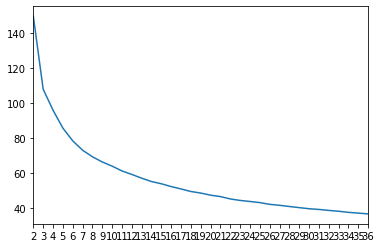

In [70]:
wyniki = pd.Series(count_wcss_scores(average_sentiments, 35))
wyniki.index += 2
plt = wyniki.plot.line(xticks = list(range(2, 37)))
plt

W żadnym momencie wykres nie "wypłaszcza się" znacząco", trudno wybrać odpowiednie k.

### Obliczenie miar dla różnych k

In [71]:
import copy
wcss_scores = {}
sillhoute_scores = {}
idb_scores = {}

for m in list(models.keys()):
    wcss_scores[m] = []
    sillhoute_scores[m] = []
    idb_scores[m] = []

    
for s in sc_scores:
    for m in list(models.keys()):
        wcss_scores[m].append(s.loc[m].iloc[0])
        idb_scores[m].append(s.loc[m].iloc[1])
        sillhoute_scores[m].append(s.loc[m].iloc[2])
    
    
for m in list(models.keys()):
    wcss_scores[m] = pd.Series(wcss_scores[m])
    idb_scores[m] = pd.Series(idb_scores[m])
    sillhoute_scores[m] = pd.Series(sillhoute_scores[m])
    wcss_scores[m].index += 2
    sillhoute_scores[m].index += 2
    idb_scores[m].index += 2
    
    
wcss_scores = pd.DataFrame.from_dict(wcss_scores)
idb_scores = pd.DataFrame.from_dict(idb_scores)
sillhoute_scores = pd.DataFrame.from_dict(sillhoute_scores)

### Wyplotowanie WCSS Score

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EBF53AB70>,
      dtype=object)

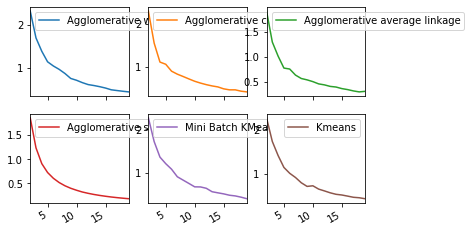

In [72]:
import warnings
warnings.filterwarnings('ignore')
wcss_scores.plot.line(subplots=True, legend=True, layout=(2, 3))

### Wyplotowanie Indeksu Davida-Bouldina

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EBE4E9F98>,
      dtype=object)

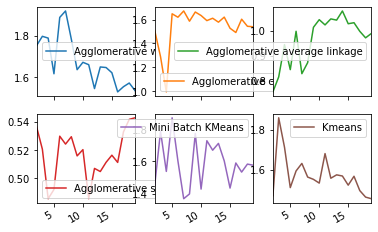

In [67]:
import warnings
warnings.filterwarnings('ignore')
idb_scores.plot.line(subplots=True, legend=True, layout=(2, 3))

### Wyplotowanie miary Silhouette

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000019EBEFBE550>,
      dtype=object)

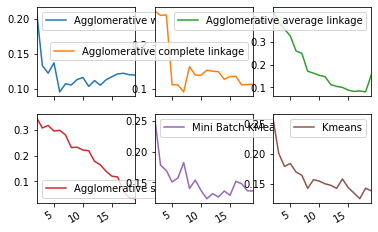

In [47]:
import warnings
warnings.filterwarnings('ignore')
sillhoute_scores.plot.line(subplots=True, legend=True, layout=(2, 3))

### Hipoteza o podziale wg ksiąg

Aby ocenić prawdziwość wcześniej podanej hipotezy, potrzebujemy nazw rodziałów i ksiąg.

In [1]:
import re
f = open('AsianReligionsData/labels.txt')
lcontent = f.read()
llines = lcontent.split("\n")
labels = []

# wybranie tylko linii z danymi
for l in llines:
    labels.append(l)
        
f.close()
labels.pop()
len(labels)

590

In [5]:
labels_general = []
for l in labels:
    labels_search = re.search('(.+)_', l)
    labels_general.append(labels_search.group(1))
len(labels_general)

590

In [29]:
set(labels_general)

{'BookOfEccleasiasticus',
 'BookOfEcclesiastes',
 'BookOfProverb',
 'BookOfWisdom',
 'Buddhism',
 'TaoTeChing',
 'Upanishad',
 'YogaSutra'}

Jak widać, mamy osiem ksiąg. Zmieńmy nazwy na liczby od 0 do 7.

In [50]:
i = -1
labels_true = []
prev = ""
for l in labels_general:
    if l != prev:
        i += 1
    prev = copy.copy(l)
    labels_true.append(copy.copy(i))

Funkcje pomocnicze, zadeklarowane w celu obliczenia metryki.

In [60]:
from sklearn import metrics


def clustering_true_pred_score(X, labels_true, k):
    df = pd.DataFrame()
    for model_key in models:
        model=models[model_key]
        model_instance = model(n_clusters=k)
        labels = model_instance.fit_predict(X)
        df.loc[model_key, "adjusted_rand_score"] = metrics.adjusted_rand_score(labels_true, labels)
    return df

In [61]:
wyniki = clustering_true_pred_score(average_sentiments, labels_true, 8)

In [62]:
wyniki

,adjusted_rand_score
Agglomerative ward linkage,0.031006
Agglomerative complete linkage,-0.009290
Agglomerative average linkage,-0.015803
Agglomerative single linkage,-0.003374
Mini Batch KMeans,0.009919
Kmeans,0.019211


Wyniki w żadnym wypadku nie przekraczają nawet 0.032, więc całkiem jasnym jest to, że podział obliczonhy na podstawie analizy sentymentów zupełnie nie pokrywa się z podziałem na księgi. Ze względu na niskie wyniki uznaliśmy, że nie ma potrzeby sprawdzania innych indeksów dla sprawdzenia poprawności.